Epoch [1/120] - Train Loss: 222.9653
Epoch [1/120] - Validation Loss: 216.6800
Best model saved with validation loss: 216.6800
Epoch [2/120] - Train Loss: 217.8488
Epoch [2/120] - Validation Loss: 215.7238
Best model saved with validation loss: 215.7238
Epoch [3/120] - Train Loss: 209.7605
Epoch [3/120] - Validation Loss: 214.9494
Best model saved with validation loss: 214.9494
Epoch [4/120] - Train Loss: 204.4459
Epoch [4/120] - Validation Loss: 209.0786
Best model saved with validation loss: 209.0786
Epoch [5/120] - Train Loss: 202.3642
Epoch [5/120] - Validation Loss: 197.9159
Best model saved with validation loss: 197.9159
Epoch [6/120] - Train Loss: 198.7781
Epoch [6/120] - Validation Loss: 202.6960
Epoch [7/120] - Train Loss: 188.1977
Epoch [7/120] - Validation Loss: 209.3372
Epoch [8/120] - Train Loss: 192.1217
Epoch [8/120] - Validation Loss: 198.9120
Epoch [9/120] - Train Loss: 195.6793
Epoch [9/120] - Validation Loss: 228.3671
Epoch [10/120] - Train Loss: 191.8616
Epoch [10/1

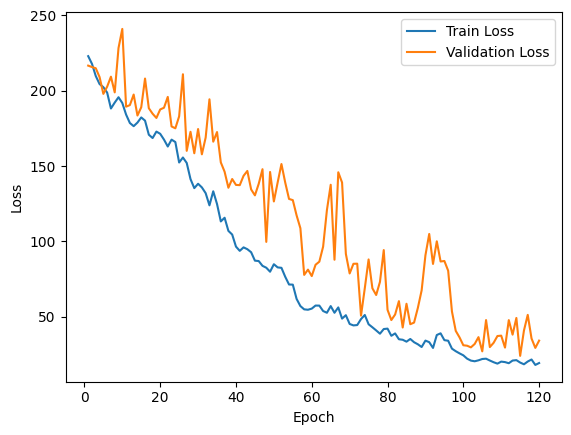

In [ ]:
from typing import Dict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import cv2
from sklearn.metrics import average_precision_score
import torch.optim as optim

# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "0"

# Split Dataset into Training and Validation Sets
from sklearn.model_selection import train_test_split

image_folder = 'image/'
mask_folder = 'mask/'
image_files = [file for file in os.listdir(image_folder) if file.endswith('.jpg')]
mask_files = [file for file in os.listdir(mask_folder) if file.endswith('.jpg')]

train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)


class DoubleConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        if mid_channels is None:
            mid_channels = out_channels
        super(DoubleConv, self).__init__(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )


class Down(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__(
            nn.MaxPool2d(2, stride=2),
            DoubleConv(in_channels, out_channels)
        )


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        x1 = self.up(x1)
        # [N, C, H, W]
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        # padding_left, padding_right, padding_top, padding_bottom
        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Sequential):
    def __init__(self, in_channels, num_classes):
        super(OutConv, self).__init__(
            nn.Conv2d(in_channels, num_classes, kernel_size=1)
        )


class UNet(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 num_classes: int = 2,
                 bilinear: bool = True,
                 base_c: int = 64):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.bilinear = bilinear

        self.in_conv = DoubleConv(in_channels, base_c)
        self.down1 = Down(base_c, base_c * 2)
        self.down2 = Down(base_c * 2, base_c * 4)
        self.down3 = Down(base_c * 4, base_c * 8)
        factor = 2 if bilinear else 1
        self.down4 = Down(base_c * 8, base_c * 16 // factor)
        self.up1 = Up(base_c * 16, base_c * 8 // factor, bilinear)
        self.up2 = Up(base_c * 8, base_c * 4 // factor, bilinear)
        self.up3 = Up(base_c * 4, base_c * 2 // factor, bilinear)
        self.up4 = Up(base_c * 2, base_c, bilinear)
        self.out_conv = OutConv(base_c, num_classes)

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.out_conv(x)

        return {"out": logits}

# 自定义数据集类
class CustomDataset(Dataset):
    def __init__(self, image_folder, mask_folder):
        self.image_files = [file for file in os.listdir(image_folder) if file.endswith('.jpg')]
        self.mask_files = [file for file in os.listdir(mask_folder) if file.endswith('.jpg')]
        self.image_folder = image_folder
        self.mask_folder = mask_folder

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder, self.image_files[idx])
        mask_path = os.path.join(self.mask_folder, self.mask_files[idx])

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = preprocess_image(image)
        mask = preprocess_mask(mask)

        # 调整输入数据维度为 [C, H, W]
        image = image.transpose((2, 0, 1))  # 通道维度移到前面
        # mask = mask.transpose((0, 1))  # 保持通道维度一致，只是将通道数改为2

        # # 扩展目标数据的通道维度，使其与模型输出通道数一致
        # mask = np.expand_dims(mask, axis=0)
        mask = np.expand_dims(mask, axis=0)  # 增加通道维度

        return {'image': image, 'mask': mask}

# 定义 preprocess_image 和 preprocess_mask 函数
def preprocess_image(image):
    # 将图像大小调整为固定尺寸（例如 1280x720）并归一化像素值
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 将 BGR 转换为 RGB
    image = cv2.resize(image, (256, 144))
    image = image.astype(np.float32) / 255.0  # 归一化像素值
    return image

def preprocess_mask(mask):
    # 将掩膜大小调整为固定尺寸（例如 1280x720），将前景和背景分别设为不同的值
    mask = cv2.resize(mask, (256, 144))
    mask[mask == 255] = 1  # 将前景（255）设为1
    mask = mask.astype(np.float32)  # 不再进行归一化
    return mask


# Create custom datasets and data loaders for training and validation
train_dataset = CustomDataset(image_folder=image_folder, mask_folder=mask_folder)
val_dataset = CustomDataset(image_folder=image_folder, mask_folder=mask_folder)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)


# Training Loop with Validation and Loss Plotting
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

# Initialize UNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, num_classes=2).to(device)

# Define loss function and optimizer (using Mean Squared Error)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
best_loss = float('inf')  # Initialize a large value as the best loss
best_model_path = 'model/best_model.pth'  # Model save path

num_epochs = 120
best_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    model.train()  # Set model to training mode
    total_train_loss = 0.0

    for batch in train_dataloader:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        optimizer.zero_grad()  # Clear gradients

        outputs = model(images)['out']  # Forward pass to get predicted masks
        # 将模型输出的通道数和目标数据的通道数匹配
        masks = masks.expand_as(outputs)
        loss = criterion(outputs, masks)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {average_train_loss:.4f}")

    # Validation
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0.0

    with torch.no_grad():
        for batch in val_dataloader:
            val_images = batch['image'].to(device)
            val_masks = batch['mask'].to(device)

            val_outputs = model(val_images)['out']  # Forward pass for validation
            val_loss = criterion(val_outputs, val_masks)  # Calculate validation loss
            total_val_loss += val_loss.item()

    average_val_loss = total_val_loss / len(val_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation Loss: {average_val_loss:.4f}")

    if average_val_loss < best_loss:
        best_loss = average_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with validation loss: {best_loss:.4f}")

    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)

# Plot training and validation losses
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from skimage.measure import label
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

# Load the trained model
best_model = UNet(in_channels=3, num_classes=2).to(device)
best_model.load_state_dict(torch.load("model/best_model.pth"))
best_model.eval()

def calculate_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    iou = np.sum(intersection) / (np.sum(union) + 1e-6)  # Add a small epsilon to avoid division by zero
    return iou

def calculate_dice(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    dice = (2 * np.sum(intersection)) / (np.sum(pred_mask) + np.sum(true_mask))
    return dice

def calculate_metrics(pred_mask, true_mask):
    iou = calculate_iou(pred_mask, true_mask)
    dice = calculate_dice(pred_mask, true_mask)

    pred_labels = label(pred_mask)
    true_labels = label(true_mask)

    conf_matrix = confusion_matrix(true_labels.flatten(), pred_labels.flatten())
    if conf_matrix.shape == (2, 2):
        tn, fp, fn, tp = conf_matrix.ravel()
    else:
        tn, fp, fn, tp = conf_matrix[0][0], conf_matrix[0][1], conf_matrix[1][0], conf_matrix[1][1]

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # Handle division by zero
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Handle division by zero
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  # Handle division by zero

    return iou, dice, precision, recall, f1

def calculate_mAP(pred_masks, true_masks):
    ap_scores = []
    for pred_mask, true_mask in zip(pred_masks, true_masks):
        precision, recall, _ = precision_recall_curve(true_mask.flatten(), pred_mask.flatten())
        ap = np.trapz(precision, recall)
        ap_scores.append(ap)
    mean_ap = np.mean(ap_scores)
    return mean_ap

def binarize_mask(pred_mask, threshold=0.5):
    binary_mask = (pred_mask > threshold).astype(np.uint8)
    return binary_mask

# Load the test dataset
test_dataset = CustomDataset(image_folder='test/', mask_folder='test_mask/')
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

pred_masks = []
true_masks = []

# Folder to save predicted masks
output_folder = 'predicted_masks01'
os.makedirs(output_folder, exist_ok=True)

for idx, batch in enumerate(test_dataloader):
    image_filename = test_dataset.image_files[idx]  # Get the corresponding image filename
    test_image = batch['image'].to(device)
    true_mask = batch['mask'][0].numpy()  # Convert the tensor to a numpy array

    with torch.no_grad():
        outputs = best_model(test_image)['out']
        pred_mask = torch.argmax(outputs, dim=1).cpu().numpy()[0]

    pred_binary_mask = binarize_mask(pred_mask)  # Convert predicted mask to binary mask
    true_binary_mask = binarize_mask(true_mask)  # Convert true mask to binary mask

    pred_masks.append(pred_binary_mask)
    true_masks.append(true_binary_mask)

    # Save the predicted mask with the same filename as the image
    pred_mask_image = (pred_binary_mask * 255).astype(np.uint8)
    save_path = os.path.join(output_folder, f'{image_filename}')
    cv2.imwrite(save_path, pred_mask_image)

pred_masks = np.array(pred_masks)
true_masks = np.array(true_masks)

# Calculate evaluation metrics
ious, dices, precisions, recalls, f1_scores = [], [], [], [], []

for pred_mask, true_mask in zip(pred_masks, true_masks):
    iou, dice, precision, recall, f1 = calculate_metrics(pred_mask, true_mask)
    ious.append(iou)
    dices.append(dice)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

mean_iou = np.mean(ious)
mean_dice = np.mean(dices)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1 = np.mean(f1_scores)

mean_ap = calculate_mAP(pred_masks, true_masks)

print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice: {mean_dice:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")
print(f"Mean Average Precision (mAP): {mean_ap:.4f}")

# 解压缩

In [ ]:
import zipfile

zip_file_name = "image01.zip" #   image 50张图像; image1 600张图像; image2 650张图像; test 13张图像

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall()

# 下载文件

In [ ]:
import shutil

# 指定要下载的文件夹路径
mask_folder_path = "predicted_masks01/"  # 根据你实际的文件夹路径进行修改

# 指定zip文件名
zip_file_name = "predicted_masks01.zip"

# 将文件夹打包成zip文件
shutil.make_archive("predicted_masks01", 'zip', mask_folder_path)

'/content/predicted_masks01.zip'

In [ ]:
from google.colab import files

# 下载zip文件
files.download(zip_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>